# Data Analysis

The following file contains for the Data Analysis section of the Evaluation chapter.

## Importing libraries

In [3]:
# imports
# deprecation warning for collections module may appear, however doesn't affect the used python version
import os
import glob
import re
import nltk
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import gaussian_kde
#from wordcloud import WordCloud

## Necessary functions

In [8]:
# function for loading the uncleaned data
def load_data(path):
    
    # load the data into one data frame, create a domain columns that indicates the domain by using the filename
    df_list = []
    for file_name in glob.glob(path):
        df_temp = pd.read_csv(file_name, delimiter = '\t', names=["label","text"], encoding='latin-1')
        df_temp['domain'] = os.path.basename(file_name)
        df_list.append(df_temp)    
    df = pd.concat(df_list, ignore_index = True)
    
    # delete empty strings
    df['text'].replace('', np.nan, inplace=True)
    df.dropna(subset=['text'], inplace=True)
    
    return df

In [7]:
# function for generating a word cloud and saving the file
def generate_wordcloud(text): 
    wordcloud = WordCloud(width=800, height=500,
                          background_color = "white",
                          relative_scaling = 1.0,
                          ).generate(text)
    
    fig = plt.figure(1, figsize=(10, 8))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
    # for saving to file
    #plt.savefig("word_cloud.png")

## Loading the data

In [9]:
# load the uncleaned data
df_train = load_data('data/uncleaned_data/train/*')
df_test = load_data('data/uncleaned_data/test/*')
df_unlabel = load_data('data/uncleaned_data/unlabelled/*')
df_train['domain'] = [re.sub('.task.train$', '', word) for word in np.array(df_train['domain'])]
df_test['domain'] = [re.sub('.task.test$', '', word) for word in np.array(df_test['domain'])]
df_unlabel['domain'] = [re.sub('.task.unlabel$', '', word) for word in np.array(df_unlabel['domain'])]
df_uncleaned = pd.concat([df_train,df_test, df_unlabel],ignore_index=True)
dfs_uncleaned = [x for _, x in df_uncleaned.groupby('domain')]

In [10]:
# load the cleaned data
with open('data/cleaned_data/merged_cleaned.p', 'rb') as f:
    df_train = pkl.load(f)
with open('data/cleaned_data/test_cleaned.p', 'rb') as f:
    df_test = pkl.load(f)

# create a list of data frames dfs, each data frame represents one domain
df = pd.concat([df_train, df_test],ignore_index=True)
dfs = [x for _, x in df.groupby('domain')]

## Analzye the data

### Numeric charactistics of each domain

In [11]:
# iterate over each domain and assess the numeric characterics
for i in range(16):
    review_length, review_length_ref = [], []
    word_freqs = Counter()
    for review in np.array(dfs[i]['text']):
        words = nltk.word_tokenize(review)
        review_length.append(len(words)) 
        for word in words:
            word_freqs[word] += 1
    for review in np.array(dfs_uncleaned[i]['text']):
        review_length_ref.append(len(nltk.word_tokenize(review))) 
    print("Domain: "+str(i))
    print("Number of samples: "+str(len(dfs[i].index)))
    print("Number of positive samples: "+str(round(sum(dfs[i]['label']))))
    print("Average review length: "+str(round(np.mean(review_length))))
    print("Average review length uncleaned: "+str(round(np.mean(review_length_ref))))
    print("Median review length: "+str(round(np.median(review_length))))
    print("Vocabulary size: "+str(round(len(word_freqs))))
    print("")

Domain: 0
Number of samples: 4000
Number of positive samples: 6986
Average review length: 11
Average review length uncleaned: 22
Median review length: 10
Vocabulary size: 11109

Domain: 1
Number of samples: 4000
Number of positive samples: 7000
Average review length: 30
Average review length uncleaned: 67
Median review length: 22
Vocabulary size: 11432

Domain: 2
Number of samples: 3900
Number of positive samples: 7000
Average review length: 52
Average review length uncleaned: 119
Median review length: 42
Vocabulary size: 13111

Domain: 3
Number of samples: 4000
Number of positive samples: 7000
Average review length: 86
Average review length uncleaned: 181
Median review length: 56
Vocabulary size: 33418

Domain: 4
Number of samples: 3997
Number of positive samples: 6999
Average review length: 69
Average review length uncleaned: 137
Median review length: 45
Vocabulary size: 13045

Domain: 5
Number of samples: 4000
Number of positive samples: 7000
Average review length: 94
Average review

### Word clouds for domains

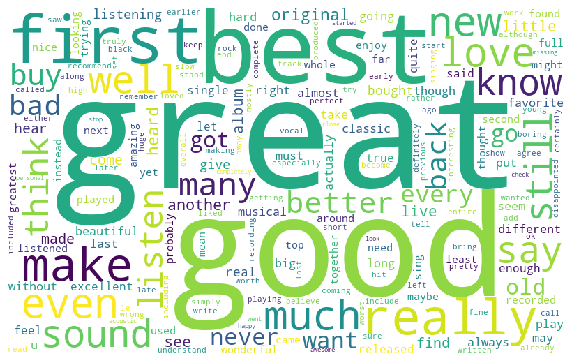

In [20]:
# pick a domain and plot word cloud
index_domain = 11
text = dfs[index_domain].text.str.cat(sep=' ')
generate_wordcloud(text)

### Distribution of word frequency per domain

In [6]:
# get the word distribution of each domain
word_counter = []
for df in dfs:
    counts = Counter()
    words = re.compile(r'\w+')
    reviews = np.array([s for s in df['text']])
    for review in reviews:
        counts.update(words.findall(review.lower()))
    word_counter.append(counts)

# the rows of df are the 16 domains, the columns are all existing words
# the number of the cells of df is the word frequency for the word in the domain
df_dist = pd.DataFrame(word_counter)
df_dist = df_dist.fillna(0)

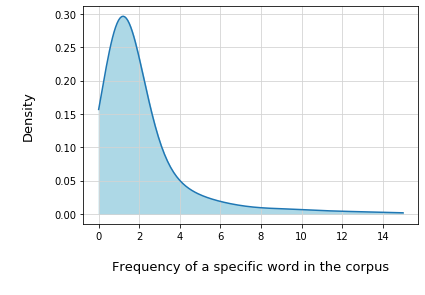

In [25]:
# pick a domain and plot the Kernel Density Estimation
index_domain = 0
data = df_dist.iloc[index_domain]
data = data[data!=index_domain]
density = gaussian_kde(data)
xs = np.linspace(0,15,200)
density.covariance_factor = lambda : .15
density._compute_covariance()
plt.plot(xs,density(xs))
plt.fill_between(xs, density(xs), y2=0, where=None, interpolate=False, color = 'lightblue')
plt.grid(True, color = 'lightgrey')
plt.xlabel('\nFrequency of a specific word in the corpus\n', fontsize = 13)
plt.ylabel('\nDensity\n', fontsize = 13)
plt.show()

#for saving to file
#plt.savefig('density.png', bbox_inches='tight')